Notebook to try various baseline upscaling estimates

In [20]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray


# import powerlaw

analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/'
# roi_pth = '/mnt/f/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp' # for small UAVSAR rois
season = 'jja' # or 'ann'
maxArea = 5000 # km2 include only lakes less than this for calc

###### vars
''' Vars 'dataset', 'roi_region', 'run' are used to generate output filename.'''
###########
# HL vars
dataset = 'HL'
variables = {'id_':'Hylak_id', 'gridcell_':'BAWLDCell_', 'area_':'Shp_Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # Note: need t o join in lat/long
gdf_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp' # HL clipped to BAWLD
# gdf_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD_roiNAHL.shp' # HL clipped to BAWLD and WBD-NAHL
useROI = False
roi_region = 'BAWLD' #'WBD' # 'Baker' # PAD, Daring, YF
run=7
roi_pth = '/mnt/g/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/WBD_convex_hull.shp' # for WBD roi
areaConversionFactor = 1 # because area already in m2
runNote = 'Trying to replicate run 00... success!'


## WBD vars
# dataset = 'WBD'
# # variables = {'id_':'OBJECTID', 'gridcell_':'BAWLDCell_', 'area_':'Area', 'long_':'BAWLDLong', 'lat_':'BAWLDLat'} # if using joined BAWLD
# variables = {'id_':'OBJECTID', 'gridcell_':'Cell_ID', 'area_':'Area', 'long_':'Long', 'lat_':'Lat'}
# gdf_pth = '/mnt/g/Other/Feng-High-res-inland-surface-water-tundra-boreal-NA/edk_out/fixed_geoms/WBD.shp' # '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/WBD_jnBAWLD.shp' # WBD NOTE: next run, use pre-joined and de-duplicated WBD
# useROI = True
# roi_region = 'WBD_BAWLD' # WBD intersect BAWLD
# run=4
# roi_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
# areaConversionFactor = 1 # because area already in m2
# runNote = 'No additional notes.'

## Sheng vars
# dataset = 'Sheng'
# variables = {'id_':'SID', 'gridcell_':'Cell_ID', 'area_':'area', 'long_':'Long', 'lat_':'Lat'}
# gdf_pth = [f'/mnt/g/Other/Sheng-Arctic-lakes/edk_out/UCLA_ArcticLakes15_{l}.shp' for l in ['AS', 'EU', 'NA']]
# useROI = True
# roi_region = 'BAWLD' # WBD intersect BAWLD
# run=6
# roi_pth = '/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip'
# areaConversionFactor = 1e6 # area is in m2, want km2
# runNote = 'No additional notes.'


################ auto update vars
#################################

## Def output paths
joined_clim_dir = os.path.join(analysis_dir, 'joined_climate', f'run{run:02}')
summ_file_pth = os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_summ.csv')
logFile_pth = os.path.join(joined_clim_dir, f'logfile_run{run:02}.txt')

## Make dirs
os.makedirs(joined_clim_dir, exist_ok=True)

## Start with Kuhn 2021 regression equations from BAWLD-CH4.

### Try to replicate coefficients

In [2]:
## Load
df = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
df.dropna(subset=['SA', 'CH4.D.FLUX', 'TEMP'], inplace=True)

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)

Filtered out 341 values (212 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.D.FLUX.LOG'],
      dtype='object')


,ï»¿ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.D.FLUX.LOG
4,5,2,Bastviken et al. 2004,WIK,2004,Sweden,Bisen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.230449
6,7,2,Bastviken et al. 2004,WIK,2004,Sweden,Grunnen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.623249


Text(0.5, 0, 'Mg CH4 / m2 /day')

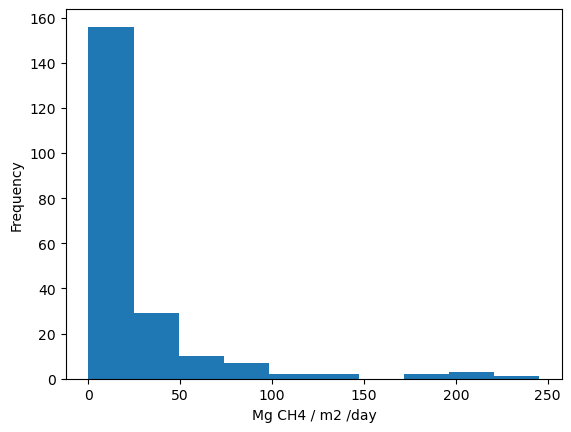

In [3]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

In [4]:
## Linear models (regression)

formula = "np.log10(Q('CH4.D.FLUX')) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula, data=df).fit()
# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log10(Q('CH4.D.FLUX'))   R-squared:                       0.300
Model:                                   OLS   Adj. R-squared:                  0.293
Method:                        Least Squares   F-statistic:                     44.76
Date:                       Mon, 13 Feb 2023   Prob (F-statistic):           6.62e-17
Time:                               11:03:45   Log-Likelihood:                -146.11
No. Observations:                        212   AIC:                             298.2
Df Residuals:                            209   BIC:                             308.3
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0465      0.118      0.395      0.693      -0.185       0.278
np.log10(SA)    -0.1575      0.030     -5.298      0.000      -0.216      -0.099
TEMP             0.0555      0.008      6.608      0.000       0.039       0.072
==============================================================================
Omnibus:                        4.111   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.708
Skew:                          -0.289   Prob(JB):                        0.157
Kurtosis:                       3.293   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
## Pull out coeffs
model1.params

Intercept       0.046480
np.log10(SA)   -0.157475
TEMP            0.055498
dtype: float64

## Apply models

In [6]:
## I/O This file is the output of QGIS join nearest and when there are multiple nearest BAWLD grid cells (didst 0) to a large lake, multiple rows are created.
## Loading is actually quicker w/o using a bounding box or mask!
# gdf = read_dataframe(gdf_pth, columns=['OBJECTID', 'Shape_Area', 'BAWLDCell_', 'BAWLDLong', 'BAWLDLat'], read_geometry=False, use_arrow=True) # pyogrio.read_dataframe(path_or_buffer, /, layer=None, encoding=None, columns=None, read_geometry=True, force_2d=False, skip_features=0, max_features=None, where=None, bbox=None, fids=None, sql=None, sql_dialect=None, fid_as_index=False, use_arrow=False)
if isinstance(gdf_pth, str): # if loading from single file
    dgdf = dgpd.read_file(gdf_pth, columns=list(variables.values())+['geometry'], chunksize=10000) # add geometry if doing spatial join
elif isinstance(gdf_pth, list): # list of files
    dgdf = dgpd.read_file(gdf_pth[0], columns=list(variables.values())+['geometry'], chunksize=10000)\
        .append(dgpd.read_file(gdf_pth[1], columns=list(variables.values())+['geometry'], chunksize=10000))\
        .append(dgpd.read_file(gdf_pth[2], columns=list(variables.values())+['geometry'], chunksize=10000)) # add geometry if doing spatial join    
else:
    raise ValueError("gdf_pth must be a str or list")


In [7]:
## Load ROI
if useROI:
    roi = gpd.read_file(roi_pth)
    if 'PAD2019' in roi_pth: # PAD ROIs have multiple features in layer
        roi.query('Region == @roi_region', inplace=True)
        roi.crs = 'ESRI:102001' # only needed if loading UAVSAR 
    # if roi.crs.to_epsg() != 4326:
    #     roi = roi.to_crs('EPSG:4326')
    if not roi.crs.is_exact_same(dgdf.crs):
        roi =roi.to_crs(dgdf.crs)
else:
    roi = None

## Continue

In [8]:
## Clip to ROI (note clip function actually clips the geometries)
# dgdf = dgpd.sjoin(dgdf, roi) # calling function from dask_geopandas doesn't work because it uses sjoin from dask, not from geopandas...
if roi is not None:
    cols = dgdf.columns
    dgdf = dgdf.sjoin(roi, how='inner')[np.unique(list(cols) + list(variables.values()))].drop_duplicates(variables['id_']) # only keep orig columns, note that sjoin can produce extra features if one-to-many
# gdfHL.plot()

## view (slow if I have to merge or drop duplicates first)
# gdf.head()
# dgdf.head()

### Side Workflow: Testing with parquet speed

In [ ]:
## Save as parquet
gdfHL = dgpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', columns=['Hylak_id', 'Shp_Area', 'BAWLDCell_', 'geometry'],
    chunksize=5000)

In [ ]:
# gdfHL.clip(roi)
type(gdfHL)
# gdfHL.clip?
gdfHL.calculate_spatial_partitions()

In [ ]:

dgpd_clip = dgpd.clip(gdfHL, roi)
dgpd_clip.compute()

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

,BAWLDCell_,Hylak_id,Shp_Area,geometry
6383,8442,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6384,8443,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6394,8442,3956,36.52,"POLYGON ((-114.25825 62.66982, -114.25536 62.6..."
6338,8442,3917,24.75,"MULTIPOLYGON (((-114.20183 62.76192, -114.2011..."
546423,7907,558888,0.78,"POLYGON ((-114.13635 62.33231, -114.13660 62.3..."
...,...,...,...,...
57,7387,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
104,7912,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
102,7911,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
97,8440,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."


In [ ]:
dgpd_clip

,BAWLDCell_,Hylak_id,Shp_Area,geometry
npartitions=8,,,,
,int64,int64,float64,geometry
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [ ]:
## Test write to parquet
parquet_out_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/test/HL_zStats_Oc_binned_jnBAWLD_Baker_clip_parquet'
dgpd_clip.to_parquet(parquet_out_pth)
# dgpd_clip.to_parquet?

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

In [ ]:
## Test read parquet file
foo2 = dgpd.read_parquet([f'{parquet_out_pth}/part.{i}.parquet' for i in range(8)])
foo2


TypeError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: GeoArrowEngine._create_dd_meta() takes 2 positional arguments but 3 were given

### Test: Join in climate data from WorldClim using pypi package latlon_utils 
(netcdf is in ~/.local/share/latlon_utils/)

In [ ]:
## Join in BAWLD attributes
gdfBAWLD = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')
gdfHL = gdfHL.merge(gdfBAWLD[['Cell_ID', 'Long', 'Lat']], left_on='BAWLDCell_', right_on='Cell_ID')

gdfHL.head(3)

,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,...,nearest_x,nearest_y,geometry,index_right,id,Region,Note,Cell_ID,Long,Lat
0,0.232737,0.198573,4.089538,95.479152,26893.426,26734.29,7387,1,0.0,-113.000000,...,-113.000000,61.500000,"POLYGON ((-109.93976 62.95851, -109.93831 62.9...",2,1,Baker,Baker - outermost,7387,-113.25,61.75
1,4.258225,4.744306,86.522316,4.475154,24.893,24.75,8442,1,0.0,-114.134654,...,-114.134654,62.852126,"POLYGON ((-114.13465 62.85213, -114.13516 62.8...",2,1,Baker,Baker - outermost,8442,-114.25,62.75
2,2.601877,2.470755,34.824528,60.102841,38.895,38.66,8442,1,0.0,-114.000000,...,-114.000000,62.576271,"POLYGON ((-113.95252 62.61332, -113.95139 62.6...",2,1,Baker,Baker - outermost,8442,-114.25,62.75


### Side workflow: Apply to BAWLD lakes to use as lookup table (don't need for main workflow)


#### Side workflow for gap-filling worldclim Temp netcdf so ocean cells take nearest land value

In [ ]:
## Verify NaNs in worldclim over oceans
get_climate(80.25, 16.25)

tavg  jan   NaN
      feb   NaN
      mar   NaN
      apr   NaN
      mai   NaN
      jun   NaN
      jul   NaN
      aug   NaN
      sep   NaN
      oct   NaN
      nov   NaN
      dec   NaN
      djf   NaN
      mam   NaN
      jja   NaN
      son   NaN
      ann   NaN
prec  jan   NaN
      feb   NaN
      mar   NaN
      apr   NaN
      mai   NaN
      jun   NaN
      jul   NaN
      aug   NaN
      sep   NaN
      oct   NaN
      nov   NaN
      dec   NaN
      djf   NaN
      mam   NaN
      jja   NaN
      son   NaN
      ann   NaN
Name: (80.25, 16.25), dtype: float64

In [ ]:
## Load worldclim data
latlong_utils_data_dir = get_data_dir()
da = xr.load_dataset(os.path.join(latlong_utils_data_dir, 'tavg_10m.nc'))

## View
da

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 2160, month: 12)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (month, lat, lon) float32 -inf -inf -inf ... -19.3 -19.28 -18.09

In [ ]:
## Practice selecting with dask
da
# da.tavg[89.92, -179.9, 2]
# daa = xr.DataArray(da)
# da.tavg[3,0,0]
da.tavg.sel(lat=[89.92, 89.75], lon=[-179.9, -179.8], month=1, method='nearest')
# da.tavg.loc[0, 89.92, -179.9]

<xarray.DataArray 'tavg' (lat: 2, lon: 2)>
array([[-inf, -inf],
       [-inf, -inf]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75
  * lon      (lon) float64 -179.9 -179.8
    month    int64 1
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

I tried using xarray.DataSet.interpolate_na, but it only works in one dim... from scipy.interpolate import NearestNDInterpolator was too complicated

In [ ]:
## Convert -inf to nan to enable filling
ds_masked = da.where(da['tavg'] != -np.inf)

## Verify
ds_masked.tavg

<xarray.DataArray 'tavg' (month: 12, lat: 1080, lon: 2160)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.87976 , -19.53003 , -19.530762, ..., -21.501526,
         -21.49524 , -20.174744],
        [-16.98999 , -17.919983, -17.919983, ..., -19.73999 ,
         -19.732727, -18.200256],
        [-17.273499, -17.862488, -17.880005, ..., -19.684753,
         -19.672241, -18.494019]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-24.55603 , -25.22998 , -25.231262, ..., -27.825012,
         -27.812988, -26.461243],
        [-22.179016, -23.252502, -23.26001 , ..., -25.646729,
         -25.63324 , -23.947754],
        [-22.613281, -23.225525, -23.22998 , ..., -25.619995,
         -25.609741, -24.393982]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.36023 , -19.015015, -19.015259, ..., -21.083496,
         -21.067505, -19.755249],
        [-16.507263, -17.432007, -17.437256, ..., -19.330017,
         -19.327515, -17.807983],
        [-16.775513, -17.360779, -17.37378 , ..., -19.295471,
         -19.279724, -18.091003]]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

In [ ]:
## Fill nans using rio
ds_masked2 = ds_masked.tavg.rio.set_spatial_dims('lon','lat', inplace=False) # inplace doesn't work
ds_masked2.rio.write_nodata(np.nan, inplace=True)
filled = ds_masked2.rio.interpolate_na()

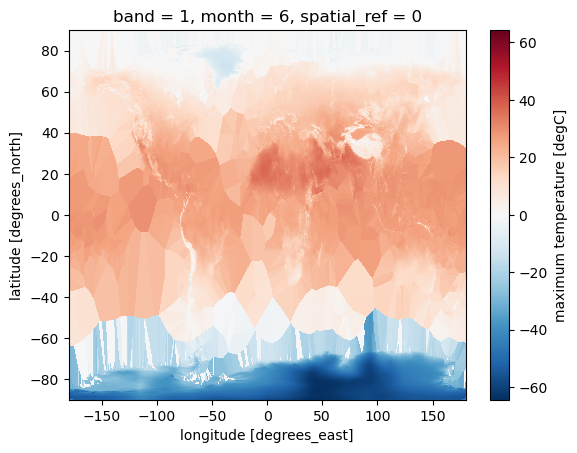

In [ ]:
## Save back to array
da['tavg'] = filled

## Plot
da.tavg.sel(month=6).plot.imshow()

## save
da.to_netcdf(os.path.join(latlong_utils_data_dir, 'tavg_10m_filled.nc'))

#### Apply to BAWLD lakes to use as lookup table (don't need for this workflow)


In [ ]:
## Load
dgdfBAWLD = dgpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip', chunksize=1000)


In [ ]:
## partitions
dgdfBAWLD.calculate_spatial_partitions()

In [ ]:
## Map function
BAWLD_clim = dgdfBAWLD.map_partitions(applyGet_climate).compute()


In [ ]:
## Join in BAWLD ID
BAWLD_clim_jn = pd.concat((BAWLD_clim.reset_index(), dgdfBAWLD['Cell_ID'].compute()), axis=1) # for some reason, just re-assigning column doesn't work


In [ ]:
## Write out
# BAWLD_clim_jn.to_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.shp')
BAWLD_clim_jn.to_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv')
print('Files written.')

Files written.


### Computing temperature means for each lake

In [ ]:
## Again dask-ify and chunk (I had to compute earlier to return groupby results to speed up future computations)
# ddf_HL = dd.from_pandas(gdfHL, chunksize=10000) 
# dgdf = dgpd.from_geopandas(gdf, chunksize=10000) # assume default sorting provides geosptial partitions, not that it shold matter

In [9]:
## Def functions
def applyGet_climate(ddf):
    '''ddf needs to have 'Lat' and 'Long' attributes'''
    return get_climate(ddf.loc[:, [variables['lat_']]].to_numpy().T.tolist()[0], ddf.loc[:, [variables['long_']]].to_numpy().T.tolist()[0],
        variables = ['tavg'], data_files=['/home/ekyzivat/.local/share/latlon_utils/tavg_10m_filled.nc'], load_data=True)['tavg'] # data_files='/home/ekyzivat/.local/share/latlon_utils/tavg_10m.nc' _filled 

## Test
# applyGet_climate(dgdf[:100].compute())
# applyGet_climate(dgdf.partitions[0]).compute()

In [10]:
## Quicker lookup function
clim_cols = ['djf','mam','jja','son','ann', 'lat', 'lon']
def lookup_climate(ddf):
    '''ddf and loaded LUT needs to have 'Lat' and 'Long' attributes'''
    lut = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv', usecols=clim_cols) # lookup table
    
    ## Join on lat/long
    joined = ddf.merge(lut, 'left', left_on=[variables['lat_'], variables['long_']], right_on=['lat', 'lon']) # for some reason, output retains both lat/long index pairs...
    # validate = 'one_to_one')
    return joined.drop(columns=[variables['lat_'], variables['long_']]) # return joined[climate cols]

## Test
# res = lookup_climate(dgdf.partitions[0]).compute() # lookup_climate(dgdf[:100].compute())
# res

In [11]:
## Apply
# df_HL_clim = ddf_HL.apply(applyGet_climate, axis=1)
# HL_clim = ddf_HL.map_partitions(applyGet_climate).compute()
meta = dict(zip([variables['id_'], variables['gridcell_'], variables['area_'], variables['long_'], variables['lat_']] + clim_cols, [float] + [int] + [float]*11)) # metadata for dask mapping # list(variables.values())
dgdf_clim = dgdf.map_partitions(lookup_climate, meta=meta, enforce_metadata=False).compute()

## View
dgdf_clim.head(3)

,BAWLDCell_,Hylak_id,Shp_Area,geometry,lat,lon,djf,mam,jja,son,ann
0,11887,2,30450.64,"POLYGON ((-119.78782 67.03574, -119.78637 67.0...",65.75,-122.25,-23.141520,-8.713399,11.148844,-4.756327,-6.365601
1,7387,3,26734.29,"POLYGON ((-109.93976 62.95851, -109.93831 62.9...",61.75,-113.25,-21.601501,-5.839335,12.582336,-0.058492,-3.729248
2,1009,4,23923.04,"POLYGON ((-98.80636 53.88021, -98.80578 53.880...",51.75,-97.75,-17.279419,0.517171,16.863505,3.289429,0.847672


## Verify, join

In [ ]:
## Shortcut: load saved data!
if not 'dgdf_clim' in locals():
    dgdf_clim = pd.read_csv(summ_file_pth)
    print(f'Loading dgdf_clim from path: {summ_file_pth}')

In [12]:
## Check that order is preserved in HL_clim (slow if using dask)
# np.all(dgdf_clim.reset_index()[['lat','lon']].to_numpy() == dgdf[[variables['lat_'], variables['long_']]].compute().to_numpy()) # 

In [13]:
## Check for duplicates # this was only possible when I had forgotten to groupby id and take first to drop duplicates in early step
dups = len(dgdf_clim[variables['id_']]) - len(dgdf_clim[variables['id_']].drop_duplicates())
if dups >0:
    print(f"Warning: {dups} duplicate {variables['id_']} found!")
    
    ## Drop duplicates! (Why were these there?...)
    dgdf_clim.drop_duplicates(subset=variables['id_'], inplace=True)

Text(0.5, 1.0, 'HL grid temperatures in BAWLD domain')

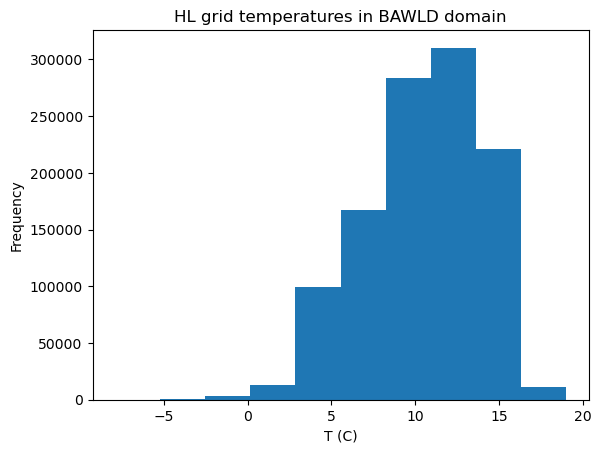

In [21]:
## Verify temp scale
dgdf_clim.jja.plot.hist()
plt.xlabel('T (C)')
plt.title(f'{dataset} grid temperatures in {roi_region} domain')

Text(0.5, 1.0, 'HL lakes in BAWLD domain')

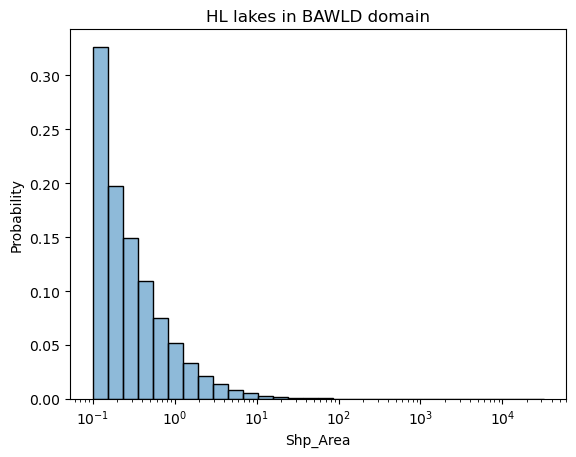

In [22]:
## View distrib of lake areas indataset
# HL_clim_jn.Shp_Area.plot.hist()
sns.histplot(data=dgdf_clim, x=variables['area_'], element="bars", log_scale=True, bins=30, palette=None, stat='probability', cumulative=False, common_norm=False, fill=True, alpha=0.5) # 
plt.title(f'{dataset} lakes in {roi_region} domain')

## Apply methane prediction and write out

In [23]:
## Flux (areal, gCH4/m2/day)
dgdf_clim['Est_mg_m2_day'] = 10**(model1.params.Intercept +
    model1.params['np.log10(SA)'] * np.log10(dgdf_clim[variables['area_']] / areaConversionFactor) 
    + model1.params['TEMP'] * dgdf_clim[season]) # jja, ann, son, mam

## Flux (flux rate, gCH4/day)
dgdf_clim['Est_g_day'] = dgdf_clim.Est_mg_m2_day * dgdf_clim[variables['area_']] * 1e3  / areaConversionFactor# (convert km2 -> m2 and mg -> g)

## View
# HL_clim_jn['Est_mg_m2_day'].head()
# HL_clim_jn['Est_g_day'].head()
## Sum! (Tg /yr)

## Sum fluxes and areas
estSum = dgdf_clim.query(f"{variables['area_']} < (@maxArea * @areaConversionFactor)")['Est_g_day'].sum() * 365.25 / 1e12
lake_area_used = dgdf_clim.query(f"{variables['area_']} < (@maxArea * @areaConversionFactor)")[variables['area_']].sum() / areaConversionFactor
with open(logFile_pth, 'w') as f:
    print(f'Run number: {run}\nDataset: {dataset}\nROI: {roi_region}\nSeason: {season}\nMax lake area used: {maxArea:,}', file=f)
    print(f'Number of lakes: {len(dgdf_clim):,}', file=f)
    print(f'NOTES: {runNote}\n', file=f)
    print(f'Emissions in BAWLD domain: {estSum:.3} Tg/yr', file=f)
    print(f"Lake area used: {lake_area_used:.4} km2", file=f)
with open(logFile_pth, 'r') as f:
    lines = f.read()
    print(lines)

Run number: 7
Dataset: HL
ROI: BAWLD
Season: jja
Max lake area used: 5,000
Number of lakes: 1,111,864
NOTES: Trying to replicate run 00... success!

Emissions in BAWLD domain: 1.4 Tg/yr
Lake area used: 1.025e+06 km2



In [17]:
## Write out dataframe
# dgdf_clim.to_csv(os.path.join(joined_clim_dir, f'{dataset}_sub{roi_region}_clim_full.csv')) # not needed / too big!
dgdf_clim[[variables['id_'], variables['area_'], 'lat', 'lon', 'djf', 'mam','jja','son','ann', 'Est_mg_m2_day', 'Est_g_day']].to_csv(summ_file_pth)
print(f'Wrote file: {summ_file_pth}')

Wrote file: /mnt/g/Ch4/GSW_zonal_stats/HL/v3/joined_climate/run07/HL_subWBD_clim_summ.csv


In [18]:
## Preview file
!head {summ_file_pth}

,Hylak_id,Shp_Area,lat,lon,djf,mam,jja,son,ann,Est_mg_m2_day,Est_g_day
0,2,30450.64,65.75,-122.25,-23.141520182291668,-8.713399251302084,11.148844401041666,-4.756327311197917,-6.3656005859375,0.9102442821298327,27717520.947193965
1,3,26734.29,61.75,-113.25,-21.60150146484375,-5.839335123697917,12.58233642578125,-0.0584920247395833,-3.729248046875,1.1158734002872581,29832083.086565644
2,4,23923.04,51.75,-97.75,-17.2794189453125,0.5171712239583334,16.863505045572918,3.2894287109375,0.8476715087890625,1.9624910296229447,46948751.4013109
3,10,17444.01,61.75,31.25,-8.420003255208334,2.16424560546875,14.700927734375,3.333577473958333,2.944686889648437,1.5645552113776953,27292116.752824627
4,11,31967.85,51.25,104.75,-17.510904947916668,-2.797078450520833,12.32232666015625,-2.47601318359375,-2.61541748046875,1.049440701123877,33548362.917422935
5,19,1058.07,66.25,-160.75,-15.87225341796875,-6.280253092447917,10.806498209635416,-3.203328450520833,-3.637334187825521,1.4788625815833334,1564740.13

### Troubleshooting Sheng

In [ ]:
dgdf.total_bounds.compute() 
''' array([-4315529.9428    , -4216258.90743544,  4976675.09842979,
        3369282.5988    ])'''

# format = minx, miny, maxx, maxy
# y, x min: -4216258.90743544, -4315529.9428    : GEOG: 33.47694881, 134.33336903
# y, x max: 3369282.5988, 4976675.09842979 : GEOG: 33.71528489, -55.90141904 ??


array([-4315529.9428    , -4216258.90743544,  4976675.09842979,
        3369282.5988    ])

In [ ]:
import pyogrio
gdf = dgdf.compute()
pyogrio.write_dataframe(gdf, '/mnt/g/Other/Sheng-Arctic-lakes/edk_out/UCLA_ArcticLakes15_cmb.shp')

Warning 1: Value 31958511907.5820312 of field area of feature 566 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 4619105503.34786987 of field area of feature 639 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 650874317.066195607 of field area of feature 674 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 114848457.08203125 of field area of feature 1287 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 175108650.353637695 of field area of feature 1624 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 242955459.452209473 of field area of feature 1633 not successfully written. Possibly due to too larger number with respect to field width
Warning 1: Value 143140926.493382931 of field area of feature 1638 not suc

In [ ]:
## For example, this feature is not in the combined shapefile I wrote out...
gdf.query('OBJECTID == 110971')

,Cell_ID,Lat,Long,OBJECTID,area,geometry
110970,14989,68.25,17.25,110971.0,89150.39917,"POLYGON ((-714447.596 2281213.055, -714330.171..."


## TODO:
* apply get_climate function over all hydrolakes using BAWLD cell lat/long X
    * Or, if worldclim netcdf is fine-scale, use individual lake lat/long
* Smart dask way is to define an entire processing chain that ends with writing out X
* Apply upscaling calc using lake area (Shp_area) and summer temp X
* If redo-ing, 
    * use lake centroid, and then no need to join to BAWLD (and slightly more nuanced, HR temp data)
    * Apply 'meta' argument to map_partitions to increase speed....
* C or K? X
* Plot, sum, profit!
* Don't need QGIS join, just use sjoin in gpd!

In [70]:
import dbfread

ModuleNotFoundError: No module named 'dbfread'

## Troubleshooting

In [ ]:
from pyogrio import read_dataframe
gdf = read_dataframe(gdf_pth, columns=['OBJECTID', 'Area', 'ID'], read_geometry=True, use_arrow=True) # pyogrio.read_dataframe(path_or_buffer, /, layer=None, encoding=None, columns=None, read_geometry=True, force_2d=False, skip_features=0, max_features=None, where=None, bbox=None, fids=None, sql=None, sql_dialect=None, fid_as_index=False, use_arrow=False)

In [ ]:
gdf.shape

(6652015, 4)

In [ ]:
gdfJ = gdf.sjoin(roi, how='inner')

In [ ]:
gdfJ.shape

(6692998, 77)

In [ ]:
gdfJ.columns

Index(['OBJECTID', 'ID', 'Shape_Area', 'geometry', 'index_right', 'Cell_ID',
       'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'GLA', 'ROC', 'TUN', 'BOR',
       'WET', 'PEB', 'WTU', 'MAR', 'BOG', 'FEN', 'LAK', 'LAL', 'MPL', 'MYL',
       'MGL', 'SPL', 'SYL', 'SGL', 'RIV', 'LAR', 'SRR', 'SRP', 'GLA_L',
       'GLA_H', 'ROC_L', 'ROC_H', 'TUN_L', 'TUN_H', 'BOR_L', 'BOR_H', 'WET_L',
       'WET_H', 'PEB_L', 'PEB_H', 'WTU_L', 'WTU_H', 'MAR_L', 'MAR_H', 'BOG_L',
       'BOG_H', 'FEN_L', 'FEN_H', 'LAK_L', 'LAK_H', 'LAL_L', 'LAL_H', 'MPL_L',
       'MPL_H', 'MYL_L', 'MYL_H', 'MGL_L', 'MGL_H', 'SPL_L', 'SPL_H', 'SYL_L',
       'SYL_H', 'SGL_L', 'SGL_H', 'RIV_L', 'RIV_H', 'LAR_L', 'LAR_H', 'SRR_L',
       'SRR_H', 'SRP_L', 'SRP_H', 'WETSCAPE'],
      dtype='object')

In [ ]:
dups = len(gdfJ['OBJECTID']) - len(gdfJ['OBJECTID'].drop_duplicates())
dups

88401

In [ ]:
## Look at dups
dupIdx = gdfJ[np.isin(gdfJ['OBJECTID'], gdfJ['OBJECTID'].drop_duplicates(keep=False), invert=True)].OBJECTID
dupIdx

155            156.0
168            169.0
169            170.0
189            190.0
155            156.0
             ...    
6641997    6641999.0
6652014    6652016.0
6652014    6652016.0
6652014    6652016.0
6652014    6652016.0
Name: OBJECTID, Length: 174219, dtype: float64

In [ ]:
gdfJ.query('OBJECTID == 156')

,OBJECTID,ID,Shape_Area,geometry,index_right,Cell_ID,Long,Lat,Area_Pct,Shp_Area,...,SGL_H,RIV_L,RIV_H,LAR_L,LAR_H,SRR_L,SRR_H,SRP_L,SRP_H,WETSCAPE
155,156.0,173662.0,3.185065e-07,"POLYGON ((-165.99944 54.16296, -165.99950 54.1...",577,1932,-165.75,54.25,21.80,3.963772e+08,...,0.86,0.18,0.46,0.0,0.05,0.02,0.25,0.18,0.52,11
155,156.0,173662.0,3.185065e-07,"POLYGON ((-165.99944 54.16296, -165.99950 54.1...",22530,1931,-166.25,54.25,4.57,8.314832e+07,...,0.63,0.15,0.42,0.0,0.05,0.00,0.35,0.16,0.63,11


In [ ]:
gdf.Area.sum()
# gdfJ.Area.sum()

AttributeError: 'GeoDataFrame' object has no attribute 'Area'